In [1]:
import torch
from pysmo.sac import sacio, sacfunc
import numpy as np
import librosa
from librosa import display
import matplotlib.pyplot as plt
import os
from tqdm import tnrange
import random
import h5py
from audio_embed import utilities
utilities.apply_style()
%matplotlib inline

# Siamese networks for triggered earthquake detection

In this work, we apply deep learning to the problem of triggered earthquake detection. Earthquake-generating zones are normally close to a failure state. Sometimes, a remote earthquake can cause an earthquake-generating zone to reach this failure state, resulting in another earthquake - a triggered earthquake. The detection of these triggered earthquakes is a difficult and error-prone process that is done by human experts. The amount of available data from seismograms all over the world makes this a very daunting task. We present a system for the automated discovery of triggered earthquakes using siamese convolutional deep networks.

## Data

We train and test our system on a set of 8 earthquakes consisting of 2311 seismograms. These seismograms are classified into two categories - they either contain a triggered earthquake (positive events) or do not (negative events). Of the 2133 seismograms, 1175 were positive events and 1136 were negative events.

Seismogram data from a single earthquake is highly correlated across all the seismograms recording the earthquake events. Training on part of the data from a single earthquake and testing on the remaining data, therefore, is trivial to get good performance on, because of the very high correlation between the training and testing data. To measure performance of our system accurately, we must train and test on different sets of earthquakes. We use the first 7 earthquakes in our dataset for training and the remaining earthquake for testing. 

Data is kept in the folder 'data_reexamined'. Each earthquake is in its own folder and is split into 3 categories, each kept in subfolders - 'positive', 'negative', and 'chaos'. This last category contains earthquakes that the human expert was unsure about. For now, these earthquakes are excluded from training and testing. In the list below, we use the first 7 earthquakes for training and the last earthquake ('SAC_20050328_XF_prem') for testing.

In [3]:
folders = [
 'SAC_20041226_2_XF_prem',
 'SAC_20021102_XF_prem',
 'SAC_20030925_XF_prem',
 'SAC_20100227_Chile_prem',
 'SAC_20030927_XF_prem',
 'SAC_20041226_XF_prem',
 'SAC_20050724_XF_prem',
 'SAC_20050328_XF_prem',
]

## Surface window

The search space for a triggered earthquake in a seismogram can be narrowed by calculating the surface window - the time period when the remote earthquake's surface waves reach the seismogram station. To do this, we first the distance $d$ between the seismogram station and the remote earthquake. The surface window can then be calculated by dividing the distance by the group velocity 5 km/s and 2 km/s. The surface window is then:

$$x[sr*d/5:sr*d/2]$$

where $x$ is the seismogram data, $sr$ is the sample rate of the data, and $d$ is the distance between the station and the remote earthquake.

The function below reads in the surface windows for each seismogram.

In [4]:
def read_surface_window(f):
    f = open(f)
    times = [s.rstrip().replace('\t', ' ').split(' ') for s in f.readlines()]
    d = {}
    for time in times:
        d[time[0].split('BH')[0]] = (float(time[1]), float(time[2]))
    f.close()
    return d

The data loading process is as follows: we go through every earthquake folder, take each seismogram in the positive and negative folders, use the surface window to read in the part of the seismogram that either contains the triggered earthquake or does not, and store the result into a list

In [5]:
def load_data(directory):
    earthquakes = []
    earthquake_files = [x for x in os.listdir(directory) if '.SAC' in x]
    progress_bar = tnrange(len(earthquake_files))
    shape = None
    if len(earthquake_files) == 0:
        return []
    
    surface_window = read_surface_window(os.path.join(directory, 'surface_window.txt'))
    for i in progress_bar:
        earthquake_file = earthquake_files[i]
        progress_bar.set_description(os.path.join(directory, earthquake_file))
        earthquake = sacio.sacfile(os.path.join(directory, earthquake_file))
        sample_rate = np.round(1./earthquake.delta)
        t, data = sacfunc.sac2xy(earthquake)
        start, stop = surface_window[earthquake_file.split('BH')[0]]
        start, stop = int(sample_rate*start), int(sample_rate*stop)
        
        data = np.array(data)[start:stop]
        if data.shape[0] == (stop - start):
            earthquakes.append(data)
    return earthquakes

positive_earthquakes = []
for i, f in enumerate(folders):
    if i == len(folders) - 1:
        positive_cutoff = len(positive_earthquakes)
        print positive_cutoff
    positive_earthquakes += load_data(os.path.join('data_reexamined', f, 'positive'))
print len(positive_earthquakes)

negative_earthquakes = []
for i, f in enumerate(folders):
    if i == len(folders) - 1:
        negative_cutoff = len(negative_earthquakes)
        print negative_cutoff
    negative_earthquakes += load_data(os.path.join('data_reexamined', f, 'negative'))
print len(negative_earthquakes)

HBox(children=(IntProgress(value=0, max=245), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=20), HTML(value=u'')))

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=105), HTML(value=u'')))

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=220), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=980), HTML(value=u'')))


1080


HBox(children=(IntProgress(value=0, max=95), HTML(value=u'')))


1175


HBox(children=(IntProgress(value=0, max=5), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=114), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=155), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=697), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=95), HTML(value=u'')))

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=20), HTML(value=u'')))


1076


HBox(children=(IntProgress(value=0, max=60), HTML(value=u'')))


1136


In all, we have 2156 number of training examples, 1080 of which are positive examples and 1076 of which are negative examples. We have 155 number of testing examples, 95 of which are positive and 60 of which are negative.

## Data representation

We design an data representation based on the characteristics of triggered earthquake events. The seismogram data is filtered into a low-pass with a cutoff of $2$ Hz and a band-pass between $2$ and $8$ Hz. Then, spectrograms of these filtered signals are taken. 

The feature extraction code is as follows:

In [9]:
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

In [10]:
def extract_features(data, sr=40.0):
    raw_data = data/np.max(np.abs(data))
    b, a = butter_highpass(5.0, sr, 2)
    high_pass = lfilter(b, a, raw_data)
    
    b, a = butter_bandpass(2.0, 8.0, sr, 2)
    band_pass = lfilter(b, a, raw_data)
    
    b, a = butter_lowpass(2.0, sr, 2)
    low_pass = lfilter(b, a, raw_data)
    
    band_spectrogram = extract_spectrogram(band_pass, 2.0, 8.0)
    high_spectrogram = extract_spectrogram(high_pass, 5.0, 7.0)
    low_spectrogram = extract_spectrogram(low_pass, 0.0, 2.0)
    
    return np.vstack([band_spectrogram, low_spectrogram])[:, :50]
    
def extract_spectrogram(data, low_cutoff, high_cutoff, sr=40):
    spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(data, n_fft=1024, hop_length=512)), ref=0.0)
    fft_frequencies = librosa.fft_frequencies(sr=sr, n_fft=1024)
    low = (np.abs(fft_frequencies - low_cutoff)).argmin()
    high = (np.abs(fft_frequencies - high_cutoff)).argmin()
    #mel_filters = librosa.filters.mel(100, 2048, n_mels=300)
    #spectrogram = np.dot(mel_filters, spectrogram)
    return spectrogram[low:high, :]

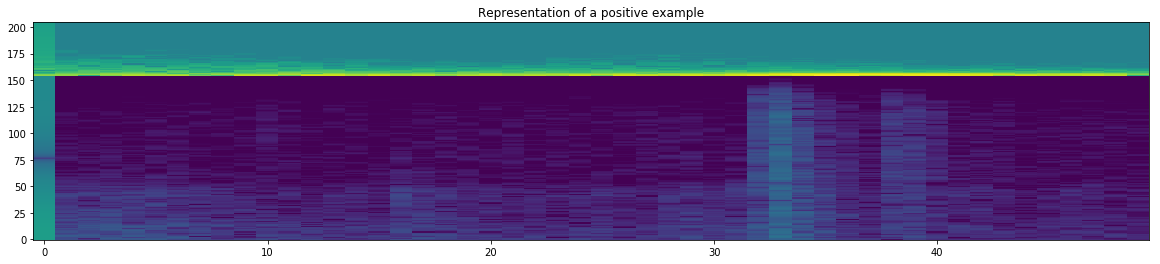

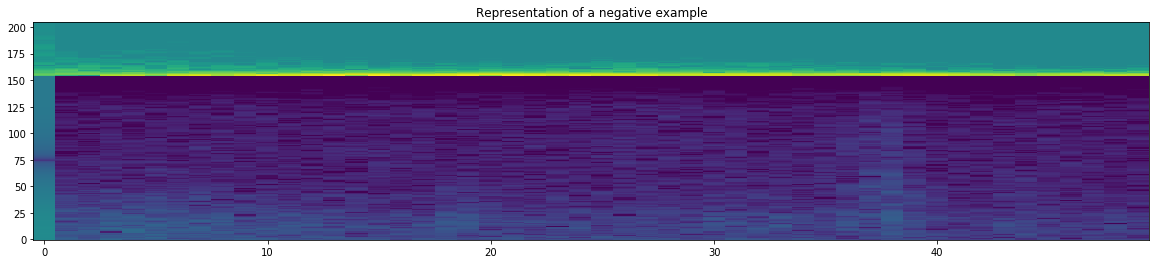

In [13]:
plt.figure(figsize=(20, 4))
plt.imshow(extract_features(positive_earthquakes[-1]), origin='lower', aspect='auto')
plt.title('Representation of a positive example')
plt.show()

plt.figure(figsize=(20, 4))
plt.imshow(extract_features(negative_earthquakes[-1]), origin='lower', aspect='auto')
plt.title('Representation of a negative example')
plt.show()

In the positive example above, a tell-tale sign of the triggered earthquake can be seen in the spectrogram (the spike aross all frequencies between frames 30 and 40. In the negative example, there is no spike.

The following code takes each seismogram, extracts the spectrogram, and stores them into an HDF5 file.

In [21]:
import h5py
shape = (1,) + extract_features(positive_earthquakes[0]).shape

dataset = h5py.File('earthquake_tutorial.h5', 'w')
dataset.create_group('training')
dataset.create_group('testing')

split = 'training'
amount_for_testing = positive_cutoff

dataset[split].create_dataset('data', 
                                   shape=shape, 
                                   maxshape=(None, None, None)) 
dataset[split].create_dataset('label', 
                                   shape=(1, 1), 
                                   maxshape=(None, None))

for i in tnrange(positive_cutoff):
    current_size = dataset[split]['data'].shape[0]
    dataset[split]['data'][current_size - 1] = extract_features(positive_earthquakes[i])
    dataset[split]['label'][current_size - 1] = 1
    dataset[split]['data'].resize(current_size + 1, axis = 0)
    dataset[split]['label'].resize(current_size + 1, axis = 0)
    
for i in tnrange(negative_cutoff):
    current_size = dataset[split]['data'].shape[0]
    dataset[split]['data'][current_size - 1] = extract_features(negative_earthquakes[i])
    dataset[split]['label'][current_size - 1] = 0
    if i < (len(negative_earthquakes) - 5) - 1:
        dataset[split]['data'].resize(current_size + 1, axis = 0)
        dataset[split]['label'].resize(current_size + 1, axis = 0)

split = 'testing'

dataset[split].create_dataset('data', 
                                   shape=shape, 
                                   maxshape=(None, None, None)) 
dataset[split].create_dataset('label', 
                                   shape=(1, 1), 
                                   maxshape=(None, None))
for i in tnrange(positive_cutoff, len(positive_earthquakes)):
    current_size = dataset[split]['data'].shape[0]
    dataset[split]['data'][current_size - 1] = extract_features(positive_earthquakes[i])
    dataset[split]['label'][current_size - 1] = 1
    dataset[split]['data'].resize(current_size + 1, axis = 0)
    dataset[split]['label'].resize(current_size + 1, axis = 0)
    
for i in tnrange(negative_cutoff, len(negative_earthquakes)):
    current_size = dataset[split]['data'].shape[0]
    dataset[split]['data'][current_size - 1] = extract_features(negative_earthquakes[i])
    dataset[split]['label'][current_size - 1] = 0
    if i < len(negative_earthquakes) - 1:
        dataset[split]['data'].resize(current_size + 1, axis = 0)
        dataset[split]['label'].resize(current_size + 1, axis = 0)

HBox(children=(IntProgress(value=0, max=1080), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=1076), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=95), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=60), HTML(value=u'')))

Finally, the data is normalized using the mean and standard deviation across the entire dataset. The normalized training data has a mean of $0$ and a standard deviation of $1$. This is to make it easier for the neural network to learn the mapping. The normalized data is then fed into a deep learning architecture for training, which we now describe.

## Network architecture

We use a convolutional neural network for predicting triggered earthquake events. Deep neural networks usually require millions of examples for effective training and generalization. Because of the rarity of triggered earthquake events and the amount of effort and expertise required to find and label these events reliably, we have access to very little training data. 

To overcome this obstacle, we use a variant of neural networks called siamese networks. Rather than classify data directly into positive and negative classes, siamese networks instead take pairs of datapoints and predict whether they belong to the same class or to different classes. They do this by projecting the datapoint into an embedding. The embeddings of two datapoints will be close to each other in the space if they belong to the same class and far apart if they belong to different classes.

In [16]:
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

def show_model(model):
    print model
    num_parameters = 0
    for p in model.parameters():
        if p.requires_grad:
            num_parameters += np.cumprod(p.size())[-1]
    print 'Number of parameters: %d' % num_parameters
    
def convert_to_tensor(data):
    tensor = torch.FloatTensor(data)
    if torch.cuda.is_available():
        tensor = tensor.cuda()
    return tensor
    
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2,2)),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(2,2)),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(2,2)),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(2,2)),
            nn.ReLU(inplace=True),
        )
        self.fc1 = nn.Sequential(
            nn.Linear(32, 10))       
        
    def forward_once(self, input_data):
        num_batch = input_data.size(0)
        input_data = input_data.unsqueeze(1)
        output = self.cnn1(input_data)
        output = F.adaptive_avg_pool2d(output, (1, 1)).squeeze(-1).squeeze(-1)
        embedding = self.fc1(output)
        #embedding = nn.functional.normalize(embedding, p=2, dim=-1)
        return embedding
    
    def forward(self, input_one, input_two):
        output_one = self.forward_once(input_one)
        output_two = self.forward_once(input_two)
        return output_one, output_two

We then take pairs of training examples and run them through the network. The loss function is a contrastive loss, which drives embeddings apart if the classes of the two examples are different and brings them closer together if the classes are the same.

In [17]:
net = SiameseNetwork().cuda()
net.train()
show_model(net)

SiameseNetwork(
  (cnn1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU(inplace)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU(inplace)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
    (7): ReLU(inplace)
  )
  (fc1): Sequential(
    (0): Linear(in_features=32, out_features=10, bias=True)
  )
)
Number of parameters: 28394


The model consists of 4 convolutional layers and non-linear activation layers (rectified linear unit or ReLU). The last ReLU layer is fed into a global average pooling layer, which averages each feature map. This is then fed into a linear layer that produces an embedding of size $10$. The network has $28394$ trainable parameters.

In [22]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

To train, we take random pairs of examples from the training data with a batch size of 256. We use the Adam optimizer with a learning rate of $1^{-4}$ and L2 regularization of $.005$. We train for 2000 iterations, which means $2000*256 = 512000$ pairs are used for training. Each data point is whitened using the mean and standard deviation.

In [25]:
def whiten(data, mean, std):
    data -= mean
    data /= std + 1e-8
    return data

def collect_data(dataset, indices):
    data = []
    labels = []
    for i in indices:
        data += [dataset['data'][i]]
        labels += [dataset['label'][i]]
    return np.array(data), np.array(labels)

The training loop for optimizing the model weights is below.

In [26]:
progress_bar = tnrange(2000)
loss_function = ContrastiveLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=0.005)
mean = np.mean(dataset['training']['data'])
std = np.std(dataset['training']['data'])
batch_size = 256

for i in progress_bar:
    a = np.random.choice(range(dataset['training']['data'].shape[0]), (batch_size,))
    b = np.random.choice(range(dataset['training']['data'].shape[0]), (batch_size,))
    
    data_one, label_one = collect_data(dataset['training'], a)
    data_two, label_two = collect_data(dataset['training'], b)
    
    data_one = whiten(data_one, mean, std)
    data_two = whiten(data_two, mean, std)
    
    data_one = Variable(convert_to_tensor(data_one))
    data_two = Variable(convert_to_tensor(data_two))
    
    same_or_different = np.array(label_one != label_two).astype(np.float)
    
    output_one, output_two = net(data_one, data_two)
    optimizer.zero_grad()
    loss = loss_function(output_one, output_two, Variable(convert_to_tensor(same_or_different)))
    loss.backward()
    optimizer.step()
    
    progress_bar.set_description(str(loss.data[0]))

HBox(children=(IntProgress(value=0, max=2000), HTML(value=u'')))

The end loss is around $.4$.

## Classifying using the embeddings

The network is used as a feature extraction step from the data representation. The features output by the network (the embeddings) are fed to a support vector machine for training a separating hyper plane. First, we can visualize the embeddings on the training data. We run each training example through the network, producing 10 dimensional embeddings for each seismogram. We then project the 10 dimensional embeddings onto a 2 dimensional space using PCA (Principal Component Analysis).

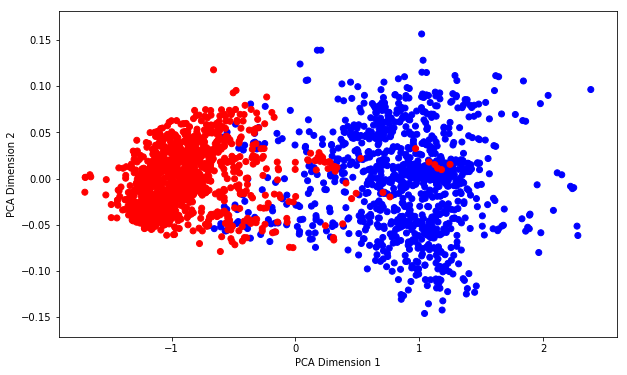

In [48]:
outputs = []
labels = []
split = 'training'
net.eval()
for i in range(dataset[split]['data'].shape[0]):
    data = whiten(dataset[split]['data'][i], mean, std)
    data = Variable(convert_to_tensor(data)).unsqueeze(0)
    label = dataset[split]['label'][i]
    labels.append(label)
    output = net.forward_once(data)
    output = output.squeeze(0).data.cpu().numpy()
    outputs.append(output)

output = np.array(outputs)

from sklearn.decomposition import PCA
transform = PCA(n_components=2)

output_transform = transform.fit_transform(output)
c = ['red', 'blue']
colors = [c[int(l[0])] for l in labels]

plt.figure(figsize=(10,6))
plt.scatter(output_transform[:, 0], output_transform[:, 1], color=colors)
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.show()

The training data is linearly separable. The dimensions of the plot are the two dimensions along which the embeddings have maximal variance. They are just for visualization. Blue indicates positive events and red indicates negative events. We can then use a Support Vector Machine with a linear kernel to find a separating hyperplane as follows. The SVM is trained on the original 10 dimensional embedding space.

In [40]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
clf = svm.SVC(kernel='linear')
clf.fit(output, np.array(labels).flatten())

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

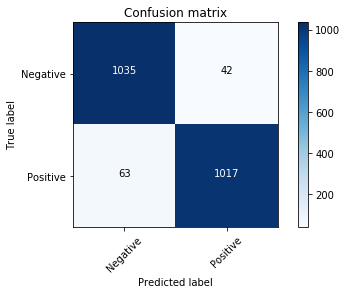

In [41]:
from sklearn.metrics import confusion_matrix
import itertools
cm = confusion_matrix(np.array(labels).flatten(), clf.predict(output))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plot_confusion_matrix(cm, ['Negative', 'Positive'])

Since the embeddings are easily linearly separable, a support vector machine with a linear kernel produces good results on the training data.

## Results

Using the trained convolutional neural network and the trained support vector machine, we are now able to classify the remaining earthquake seismogram data into containing triggered events or not.

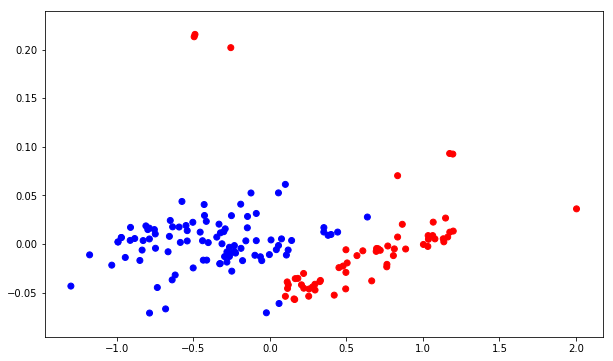

In [47]:
outputs = []
labels = []
split = 'testing'
net.eval()
for i in range(dataset[split]['data'].shape[0]):
    data = whiten(dataset[split]['data'][i], mean, std)
    data = Variable(convert_to_tensor(data)).unsqueeze(0)
    label = dataset[split]['label'][i]
    labels.append(label)
    output = net.forward_once(data)
    output = output.squeeze(0).data.cpu().numpy()
    outputs.append(output)

output = np.array(outputs)

from sklearn.decomposition import PCA
transform = PCA(n_components=2)

output_transform = transform.fit_transform(output)
c = ['red', 'blue']
colors = [c[int(l[0])] for l in labels]

plt.figure(figsize=(10,6))
plt.scatter(output_transform[:, 0], output_transform[:, 1], color=colors)
plt.show()

Accuracy: 0.851612903226


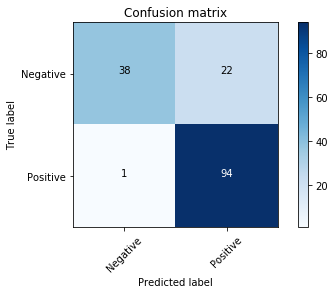

In [46]:
from sklearn.metrics import confusion_matrix
import itertools
cm = confusion_matrix(np.array(labels).flatten(), clf.predict(output))    
plot_confusion_matrix(cm, ['Negative', 'Positive'])

print 'Accuracy: ' +  str(np.sum(np.array(labels).flatten() == clf.predict(output)) / float(len(labels)))

We obtain an accuracy on the testing set of $85.1$ percent. We rarely classify a positive example as a negative one, but sometimes confuse negative examples for positive examples. There are 95 positive examples and 60 negative examples. So if we always guess the more common class (positive), we'd only have an accuracy of $61.2$ percent.